In [13]:
#Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
holidays = pd.read_csv('/content/holidays_events.csv',parse_dates=['date'])
oil = pd.read_csv('/content/oil.csv',parse_dates=['date'])
stores = pd.read_csv('/content/stores.csv')
transactions = pd.read_csv('/content/transactions.csv',parse_dates=['date'])

In [4]:
train = pd.read_csv('/content/train.csv',parse_dates=['date'])
test = pd.read_csv('/content/test.csv',parse_dates=['date'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assuming 'df' is your merged and preprocessed dataframe
X = df[['feature1', 'feature2', ...]]  # Select your features
y = df['sales']  # Target variable

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

In [6]:
# Step 1: Rename 'type' to 'holiday_type' in data_holidays
holidays = holidays.rename(columns={'type': 'holiday_type'})
print("\nColumns in data_holidays after renaming:")
print(holidays.columns)

# Step 2: Feature Engineering - Create date-related features
for data in [oil, holidays, train, transactions, test]:
    if 'date' in data.columns:
        data['year'] = data['date'].dt.year
        data['month'] = data['date'].dt.month
        data['day'] = data['date'].dt.day
        data['day_of_week'] = data['date'].dt.dayofweek
        data['day_name'] = data['date'].dt.strftime('%A')

# Step 3: Merge datasets
# Merge oil data
train = train.merge(oil[['date', 'dcoilwtico']], on='date', how='left')
test = test.merge(oil[['date', 'dcoilwtico']], on='date', how='left')
oil = oil.drop(columns=['dcoilwtico'])

# Merge holidays data
train = train.merge(
    holidays,
    on=['date', 'day', 'month', 'year', 'day_of_week', 'day_name'],
    how='left'
)
test = test.merge(
    holidays,
    on=['date', 'day', 'month', 'year', 'day_of_week', 'day_name'],
    how='left'
)

# Merge stores data
train = train.merge(
    stores.rename(columns={'type': 'store_type'}),
    on='store_nbr',
    how='left'
)
test = test.merge(
    stores.rename(columns={'type': 'store_type'}),
    on='store_nbr',
    how='left'
)

# Merge transactions data
train = train.merge(
    transactions,
    on=['date', 'store_nbr', 'day', 'month', 'year', 'day_of_week', 'day_name'],
    how='left'
)
test = test.merge(
    transactions,
    on=['date', 'store_nbr', 'day', 'month', 'year', 'day_of_week', 'day_name'],
    how='left'
)

# Step 4: Aggregate sales across all stores
data_agg = train.groupby('date').agg({
    'sales': 'sum',
    'dcoilwtico': 'mean',
    'transactions': 'mean'
}).reset_index()

# Step 5: Merge holiday information
holidays = holidays[holidays['locale'] == 'National']  # Considering only national holidays
print("\nColumns in holidays DataFrame:")
print(holidays.columns)

# Ensure 'holiday_type' exists before selecting
if 'holiday_type' in holidays.columns:
    data_agg = data_agg.merge(
        holidays[['date', 'holiday_type']],
        on='date',
        how='left'
    )
    print("Merged 'holiday_type' successfully.")
else:
    print("Error: 'holiday_type' column does not exist in holidays DataFrame.")

# Step 6: Handle missing values
data_agg['holiday_type'].fillna('None', inplace=True)
data_agg['dcoilwtico'].fillna(method='ffill', inplace=True)
data_agg['transactions'].fillna(method='ffill', inplace=True)

# Step 7: Feature Engineering - Additional time-based features
data_agg['year'] = data_agg['date'].dt.year
data_agg['month'] = data_agg['date'].dt.month
data_agg['day'] = data_agg['date'].dt.day
data_agg['day_of_week'] = data_agg['date'].dt.dayofweek
data_agg['day_name'] = data_agg['date'].dt.strftime('%A')

# Step 8: Encode categorical variables
data_agg = pd.get_dummies(data_agg, columns=['holiday_type', 'day_name'], drop_first=True)

# Step 9: Set date as index
data_agg.set_index('date', inplace=True)

# Step 10: Verify the first few rows of the aggregated data
print("\nAggregated Data:")
print(data_agg.head())



Columns in data_holidays after renaming:
Index(['date', 'holiday_type', 'locale', 'locale_name', 'description',
       'transferred'],
      dtype='object')

Columns in holidays DataFrame:
Index(['date', 'holiday_type', 'locale', 'locale_name', 'description',
       'transferred', 'year', 'month', 'day', 'day_of_week', 'day_name'],
      dtype='object')
Merged 'holiday_type' successfully.

Aggregated Data:
                    sales  dcoilwtico  transactions  year  month  day  \
date                                                                    
2013-01-01    2511.618999         NaN    770.000000  2013      1    1   
2013-01-02  496092.417944       93.14   2026.413043  2013      1    2   
2013-01-03  361461.231124       92.97   1706.608696  2013      1    3   
2013-01-04  354459.677093       93.12   1706.391304  2013      1    4   
2013-01-05  477350.121229       93.12   2034.195652  2013      1    5   

            day_of_week  holiday_type_Event  holiday_type_Holiday  \
date    

In [7]:
# Step 1: Split the data into training and testing sets based on time
# We'll use the last 30 days for testing
split_date = data_agg.index.max() - pd.Timedelta(days=30)
train_data = data_agg[data_agg.index <= split_date]
test_data = data_agg[data_agg.index > split_date]

print(f"Training data from {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data from {test_data.index.min()} to {test_data.index.max()}")

# Step 2: Define the target variable and exogenous variables
y_train = train_data['sales']
X_train = train_data.drop(columns=['sales'])

y_test = test_data['sales']
X_test = test_data.drop(columns=['sales'])


Training data from 2013-01-01 00:00:00 to 2013-08-28 00:00:00
Testing data from 2013-08-29 00:00:00 to 2013-09-27 00:00:00


In [8]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [15]:

y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2_score}")

Mean Squared Error: 3041983132.84276
Root Mean Squared Error: 55154.176023604596
Mean Absolute Error: 28647.539073342257
R-squared Score: 0.7645977341905283


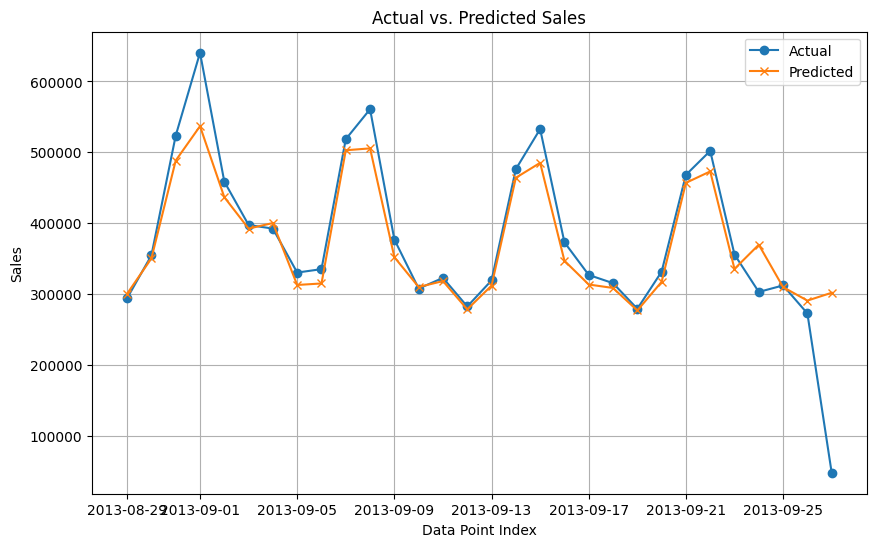

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
plt.xlabel('Data Point Index')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Sales')
plt.legend()
plt.grid(True)
plt.show()